In [154]:
import numpy as np
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import skimage as si
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy import ndimage

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

C:\Users\klaud\AppData\Local\Temp\ipykernel_15840\3070808143.py:13: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


# Import images


In [140]:
DATA_DIR = "./Real/"
images = glob.glob(DATA_DIR + "*.BMP")

#count images
print(len(images))

6000


(103, 96, 3)
(103, 96, 3)


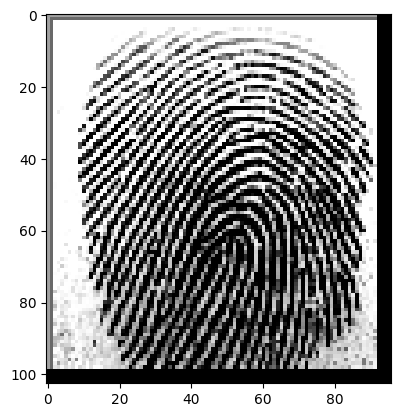

In [141]:
image1 = cv2.imread(images[0], cv2.COLOR_BGR2GRAY)
image2 = cv2.imread(images[2999], cv2.COLOR_BGR2GRAY)
image3 = cv2.imread(images[5999], cv2.COLOR_BGR2GRAY)
test1 = si.color.rgb2gray(image1)
print(np.shape(image1))
print(np.shape(image1))
pltImage1 = plt.imshow(image1)



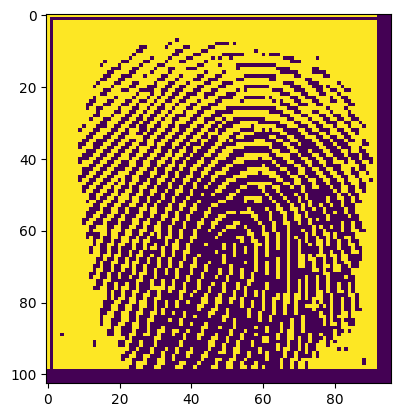

In [153]:
image1_0 = cv2.imread(images[0], 0)
ret1,th1 = cv2.threshold(image1_0,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th1)

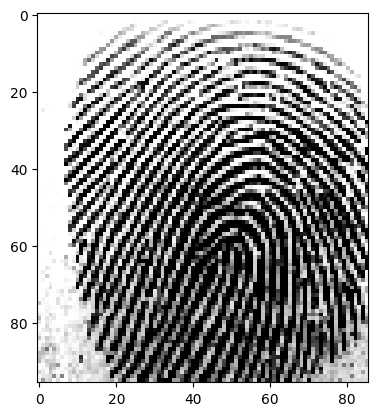

In [206]:
result = ndimage.prewitt(image1_0)
plt.imshow(result)
left = 2
top = 2
right = 88
bottom = 98
im = Image.open(images[0]).convert('RGB')
imgcropped =  im.crop((left, top, right, bottom))
plt.imshow(imgcropped)

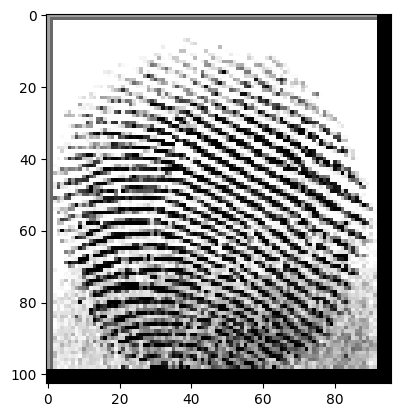

In [142]:
pltImage2 = plt.imshow(image2)


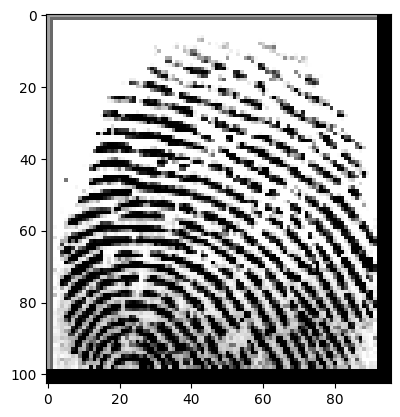

In [143]:
pltImage3 = plt.imshow(image3)

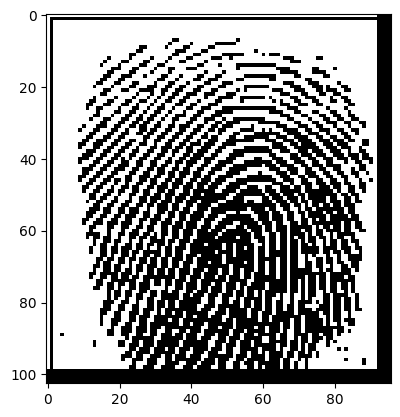

In [251]:
img1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
thresh = 128

maxval = 255

im_bin = (image1 > thresh) * maxval

plt.imshow(im_bin)

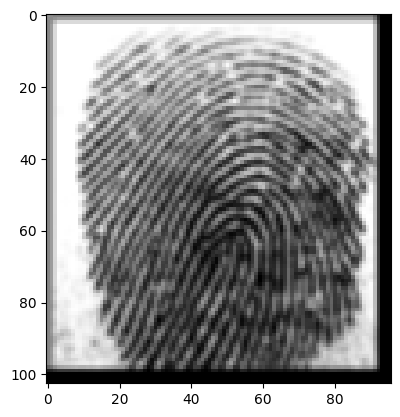

In [145]:
# Apply gaussian blur to remove noise
blurred1 = cv2.GaussianBlur(image1, (3,3), 0)
plt.imshow(blurred1)

C:\Users\klaud\AppData\Local\Temp\ipykernel_15840\2462248264.py:41: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


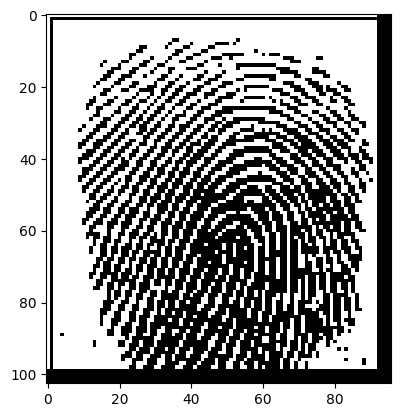

In [146]:
ret,img = cv2.threshold(image1, 127, 255, 0)

# Step 1: Create an empty skeleton
size = np.size(img)
skel = np.zeros(img.shape, np.uint8)
kernel = np.ones((3,3))
# Get a Cross Shaped Kernel
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

plt.imshow(img)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, element)
dilated = cv2.dilate(img, element, iterations = 1)
open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
plt.imshow(dilated)
#plt.imshow(closing)
# while i<6:
#     #Step 2: Open the image
#     open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
#     #Step 3: Substract open from the original image
#     temp = cv2.subtract(img, open)
#     #Step 4: Erode the original image and refine the skeleton
#     eroded = cv2.erode(img, element)
#     skel = cv2.bitwise_or(skel,temp)
#     img = eroded.copy()
#     i=i+1
#     # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
#     # if cv2.countNonZero(img)==0:
#     #     break
# plt.imshow(img)


#ret, thresh = cv2.threshold(image1, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find minutiae points


# # Displaying the final skeleton
# cv2.imshow("Skeleton",skel)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
from scipy.ndimage.filters import convolve
gray_img = Image.fromarray(img)
vertical_sobel_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
horizontal_sobel_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

# vertical_prewitt_filter = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
# horizontal_prewitt_filter = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
# print(gray_img)
# convolved_img2 = ndimage.convolve(gray_img, vertical_prewitt_filter)
# convolved_img2 = ndimage.convolve(convolved_img2, horizontal_prewitt_filter)

aa = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
a2 = cv2.Sobel(aa, cv2.CV_64F, 1, 0, ksize=3)
closing = cv2.morphologyEx(a2, cv2.MORPH_CLOSE, element)
dilated = cv2.dilate(a2, kernel, iterations = 1)
eroded = cv2.erode(a2, element, iterations = 1)
plt.imshow(img)

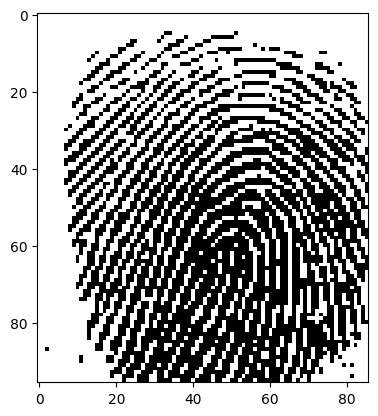

In [207]:
t_lower = 100  # Lower Threshold
t_upper = 200
edge = cv2.Canny(img, t_lower, t_upper)
plt.imshow(edge)

thresh = 128

maxval = 255

im_bin_c = (np.asarray(imgcropped) > thresh) * maxval

plt.imshow(im_bin_c)

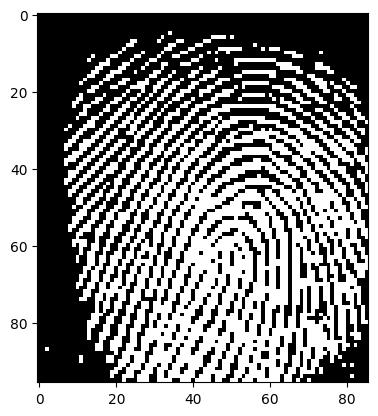

In [263]:
img_arr = np.asarray(imgcropped)
#print(im_bin_c)
tmp_img = im_bin_c/255.0
#result = [map(int,i) for i in tmp_img]

thresh = 130

maxval = 255
newimg = np.invert(img_arr)
eroded = cv2.erode(newimg, kernel, iterations = 1)
im_bin_c_rev = (newimg > thresh) * maxval

plt.imshow(im_bin_c_rev)
#plt.imshow(newimg)


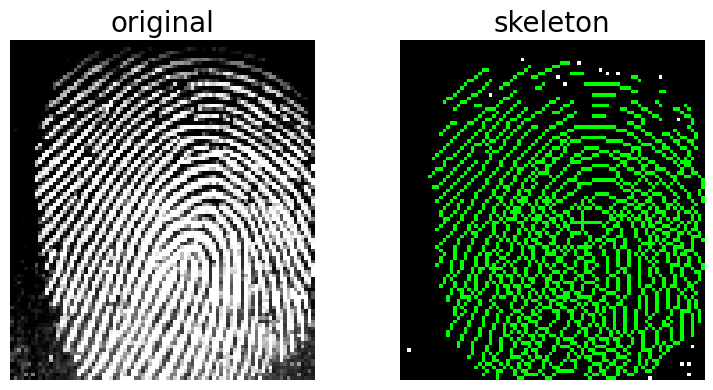

In [264]:
from skimage.morphology import skeletonize
skeleton = skeletonize(im_bin_c_rev)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(newimg, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()


# Create arrays of terminations and bifurcations


In [266]:
(rows, cols, color) =skeleton.shape
shape = (skeleton.shape[0], skeleton.shape[1])
minutiaeTerm = np.zeros(shape)
minutiaeBif = np.zeros(shape)
green = [0, 255, 0]
black = [0, 0, 0]
for i in range(1,rows-1):
    for j in range(1,cols-1):
        #print(skeleton[i,j])
        if((skeleton[i][j] == green).all()):
            block = skeleton[i-1:i+2,j-1:j+2]
            block_val = np.sum(block)/255
            if(block_val == 2):
                minutiaeTerm[i,j] = 1
            elif(block_val == 4):
                minutiaeBif[i,j] = 1


In [267]:
print(minutiaeBif)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
